## Project Description

In this notebook, I will tell you about building my submission to the [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) competition hosted by [DrivenData](https://www.drivendata.org/). The competition problem uses data about waterpoints (pumps, wells, etc.) in Tanzania collected by a partnership between [Taarifa](http://taarifa.org/) and the [United Republic of Tanzania Ministry of Water](https://www.maji.go.tz/) to predict if they are currently in need of repair. By better understanding what factors predict issues with water points, we hope to improve access to potable water in Tanzania and reduce operational costs associated with maintaining water infrastructure. 

For the purposes of the competition, the model is assessed in terms of the classification rate, also commonly called [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision).The classification rate is a number between zero and one with zero indicating that all prediction were wrong, one indicating all predictions were correct, and 0.7 indicating that, on average, seven out of ten predictions are correct.

All relevant data and code is available in the project [github repository](https://github.com/sethchart/Pump-it-Up-Data-Mining-the-Water-Table).

## Initial Setup
Below we setup the notebook for the task at hand.

### Importing Required Modules
Below I collect the tools that I will use throughout the notebook.

In [33]:
#Basics
import pandas as pd
import numpy as np
from itertools import combinations

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')

#Train Test Split
from sklearn.model_selection import train_test_split

# Imputer
from sklearn.impute import SimpleImputer

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer,FunctionTransformer

#Resampler
from imblearn.over_sampling import SMOTE

# Classifiers
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

#Pipeline
from imblearn.pipeline import Pipeline

#Grid Search
from sklearn.model_selection import GridSearchCV

# Model evaluation
from sklearn.metrics import plot_confusion_matrix

### Set Random State
The random state to be used whenever a randomized process is initiated.

In [34]:
random_state = 42

## Importing the Data
The data for this project was downloaded from the competition page [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/). Because of the submission format requirements for the competition, it is vital that we retain the index column throughout modeling so that we are able to produce predictions that can be validated using the competition's validation data. Data is stored in the `data` folder in the project [github repository](https://github.com/sethchart/Pump-it-Up-Data-Mining-the-Water-Table).

In [35]:
features = pd.read_csv('../data/training_features.csv', index_col='id')
targets = pd.read_csv('../data/training_labels.csv', index_col='id')
df = features.join(targets, how='left')
X = df.drop('status_group', axis=1)
y = df['status_group']

### Test Train Split
For the purposes of model tuning we hold 10% of the data out for local testing.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

## About the Data
The provided data set contains thirty-nine features and one target. There are 59,400 rows of data.

In [37]:
print(df.shape)

(59400, 40)


From this point forward we will only inspect the training data contained in `X_train` and `y_train`.

In [38]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (53460, 39)
y_train shape:  (53460,)


The summary below provides a description of data types and the number of non-null values for each variable. I will inspect variables more carefully later.

In [39]:
display(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 31080 to 23812
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             53460 non-null  float64
 1   date_recorded          53460 non-null  object 
 2   funder                 50179 non-null  object 
 3   gps_height             53460 non-null  int64  
 4   installer              50160 non-null  object 
 5   longitude              53460 non-null  float64
 6   latitude               53460 non-null  float64
 7   wpt_name               53460 non-null  object 
 8   num_private            53460 non-null  int64  
 9   basin                  53460 non-null  object 
 10  subvillage             53132 non-null  object 
 11  region                 53460 non-null  object 
 12  region_code            53460 non-null  int64  
 13  district_code          53460 non-null  int64  
 14  lga                    53460 non-null  object 
 15

None

### Target
The target for this data set is `status_group`, which indicates whether a water point is 'functional', 'functional needs repair', or 'non functional'. Therefore, ours is a multi-class classification problem as opposed to a binary classification problem.

In [40]:
print('Target classes: ', y_train.unique())

Target classes:  ['functional' 'non functional' 'functional needs repair']


### Geographical data
There are several variables that describe the geography of waterpoints. These variables fall into two categories.

#### Numerical
The variables below provide geo-spatial coordinates for the waterpoint. By inspecting a map I was able to provide the the bounds below for these coordinates.
* `longitude` - GPS coordinate. Valid values fall in the interval [29.6, 40.4].
* `latitude` - GPS coordinate. Valid values fall in the interval [-11.7, -0.8].
* `gps_height` - Altitude of the well. Valid values fall in the interval [0, 5895] meters. [Reference](https://en.wikipedia.org/wiki/Geography_of_Tanzania)

There are no missing values for these varables.

In [41]:
geoNum = X_train[['longitude', 'latitude', 'gps_height']]
print(geoNum.isnull().any())

longitude     False
latitude      False
gps_height    False
dtype: bool


Now let's inspect the distribution of the geospatial coordinates.

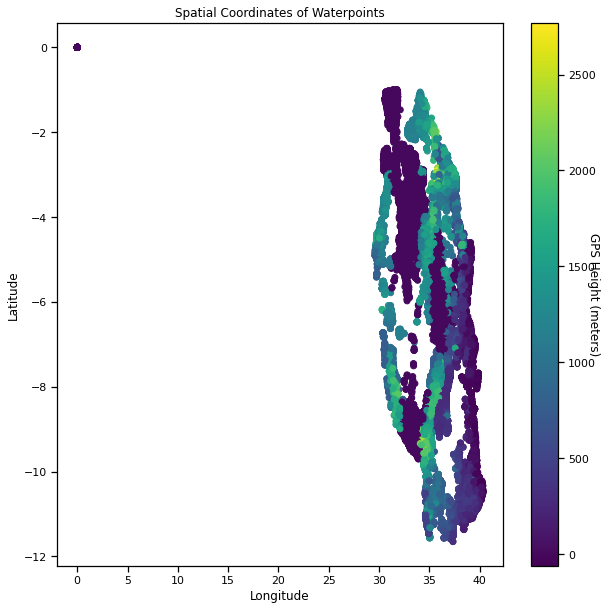

In [42]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x='longitude', y='latitude', c='gps_height', data=geoNum)
cbar = plt.colorbar()
cbar.set_label('GPS Height (meters)', rotation=270);
plt.title('Spatial Coordinates of Waterpoints');
plt.xlabel('Longitude');
plt.ylabel('Latitude');
fig.savefig('../images/geo-spatial_coordinates.png', bbox_inches='tight')

Notice that there are waterpoints with latitude and longitude equal to zero. These are almost surely waterpoints with missing values that have been encoded using dummy values. Let's take a look at the values that fall outside of the allowed intervals.

In [43]:
geoNumBad = X_train[['longitude', 'latitude', 'gps_height']].query(
    'longitude < 29.6 or longitude >40.4 or latitude < -11.7 or latitude > -0.8 or gps_height < 0 or gps_height > 5895'
)
print(f'There are {len(geoNumBad)} rows, roughly {round(len(geoNumBad)/len(df)*100)}% of our data, with geospatial coordinates that fall outside our bounds.')
display(geoNumBad.value_counts())

There are 2973 rows, roughly 5% of our data, with geospatial coordinates that fall outside our bounds.


longitude  latitude       gps_height
0.000000   -2.000000e-08   0            1621
38.994109  -6.480816e+00  -7               1
38.990750  -6.537670e+00  -11              1
38.991011  -6.537616e+00  -8               1
38.991060  -6.530981e+00  -9               1
                                        ... 
39.506753  -7.157563e+00  -34              1
39.507581  -7.160888e+00  -11              1
39.508603  -8.520567e+00  -44              1
39.508744  -8.520694e+00  -38              1
39.284854  -8.390836e+00  -34              1
Length: 1353, dtype: int64

#### Categorical
Tanzania is organized into 31 [administrative regions](https://en.wikipedia.org/wiki/Regions_of_Tanzania). Each of these regions are subdivided into [districts](https://en.wikipedia.org/wiki/Districts_of_Tanzania). Each district contains wards which, in turn, contain sub-villages. The variables below describe the location of a waterpoint in terms of this naming scheme. The regions and districts are coded, however I was not able to reconcile the codes with any publicly available encoding scheme.
* `region` (`region_code`)  - Names (codes) for top-level administrative regions.
* `lga` (`district_code`) - Names (codes) for districts, which divide regions.
* `ward` - Names for wards, which divide districts.
* `subvillage` - Names for sub-villages, presumably these subdivide wards. 

In this group, only the variable `subvillage` has missing values. 

In [44]:
regional = X_train[['region', 'lga', 'ward', 'subvillage']]
print(regional.isnull().any())

region        False
lga           False
ward          False
subvillage     True
dtype: bool


In [45]:
for col in regional.columns:
    print(f'- {col} has {len(regional[col].unique())} unique values.')

- region has 21 unique values.
- lga has 125 unique values.
- ward has 2089 unique values.
- subvillage has 18284 unique values.


In [46]:
lst = list(X_train['region'].unique())
print(f'Our data contains information about waterpoints in the following {len(lst)} regions:\n')
print(lst)

Our data contains information about waterpoints in the following 21 regions:

['Tabora', 'Mtwara', 'Morogoro', 'Shinyanga', 'Kilimanjaro', 'Tanga', 'Mwanza', 'Mbeya', 'Arusha', 'Ruvuma', 'Iringa', 'Singida', 'Pwani', 'Rukwa', 'Dodoma', 'Kigoma', 'Kagera', 'Lindi', 'Mara', 'Manyara', 'Dar es Salaam']


The function below takes a

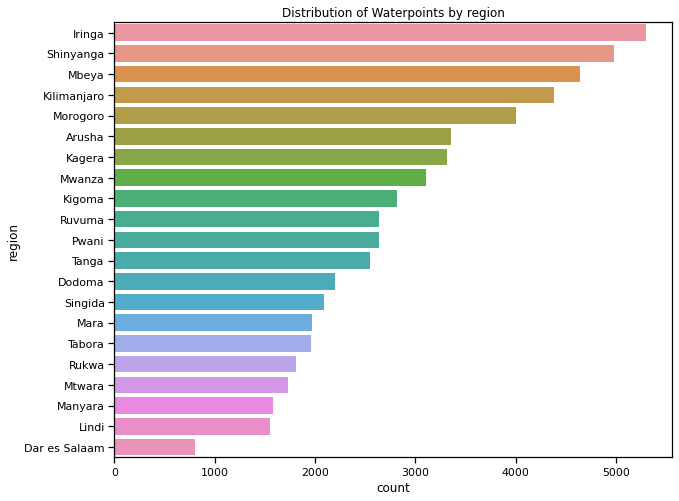

In [47]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
ax.set_title('Distribution of Waterpoints by region')
sns.countplot(y='region', data=df, order=df['region'].value_counts().index, ax=ax);
fig.savefig('../images/waterpoints_by_region.png', bbox_inches='tight')

Below I have counted all of the combinations of values of `region` and `region_code`. It looks like some regions have multiple codes, but the region codes do not provide substantially more information than the region names.

In [48]:
lst = sorted(list(X_train['lga'].unique()))
print(f'Our data contains information about waterpoints in the following {len(lst)} districts:\n')
print(lst)

Our data contains information about waterpoints in the following 125 districts:

['Arusha Rural', 'Arusha Urban', 'Babati', 'Bagamoyo', 'Bahi', 'Bariadi', 'Biharamulo', 'Bukoba Rural', 'Bukoba Urban', 'Bukombe', 'Bunda', 'Chamwino', 'Chato', 'Chunya', 'Dodoma Urban', 'Geita', 'Hai', 'Hanang', 'Handeni', 'Igunga', 'Ilala', 'Ileje', 'Ilemela', 'Iramba', 'Iringa Rural', 'Kahama', 'Karagwe', 'Karatu', 'Kasulu', 'Kibaha', 'Kibondo', 'Kigoma Rural', 'Kigoma Urban', 'Kilindi', 'Kilolo', 'Kilombero', 'Kilosa', 'Kilwa', 'Kinondoni', 'Kisarawe', 'Kishapu', 'Kiteto', 'Kondoa', 'Kongwa', 'Korogwe', 'Kwimba', 'Kyela', 'Lindi Rural', 'Lindi Urban', 'Liwale', 'Longido', 'Ludewa', 'Lushoto', 'Mafia', 'Magu', 'Makete', 'Manyoni', 'Masasi', 'Maswa', 'Mbarali', 'Mbeya Rural', 'Mbinga', 'Mbozi', 'Mbulu', 'Meatu', 'Meru', 'Misenyi', 'Missungwi', 'Mkinga', 'Mkuranga', 'Monduli', 'Morogoro Rural', 'Morogoro Urban', 'Moshi Rural', 'Moshi Urban', 'Mpanda', 'Mpwapwa', 'Mtwara Rural', 'Mtwara Urban', 'Mufindi', 

### Water Table
The variables below describe the water that is being accessed by the waterpoint.
* `basin` - Geographic water basin.
* `water_quality` - The quality of the water.
* `quality_group` - The quality of the water.
* `quantity` - The quantity of water.
* `quantity_group` - The quantity of water.
* `source` - The source of the water.
* `source_type` - The source of the water.
* `source_class` - The source of the water.

There are no missing values in this group.

In [49]:
waterTable = X_train[['basin', 'water_quality', 'quality_group', 'quantity', 
    'source', 'source_type', 'source_class']]
waterTable.isnull().any()

basin            False
water_quality    False
quality_group    False
quantity         False
source           False
source_type      False
source_class     False
dtype: bool

Below I have plotted the distribution of waterpoints with respect to each of the variables in this group. Notice that `water_quality` and `quality_group` have nearly identical distributions and values. Similarly, `source` and `source_type` have nearly identical distributions and values. 

In [50]:
def barplot_waterpoints(df):
    for col in df.columns:
        fig, ax = plt.subplots()
        fig.set_figheight(8)
        fig.set_figwidth(10)
        ax.set_title(f'Distribution of Waterpoints by {col}')
        sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=ax);
        fig.savefig(f'../images/waterpoints_by_{col}.png', bbox_inches='tight')

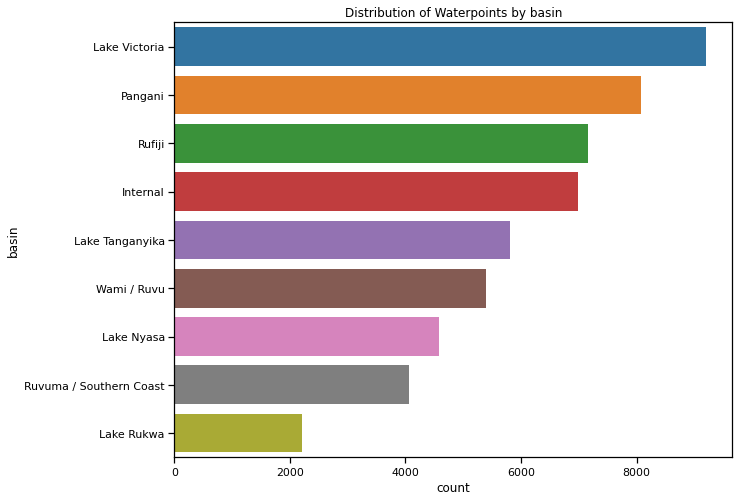

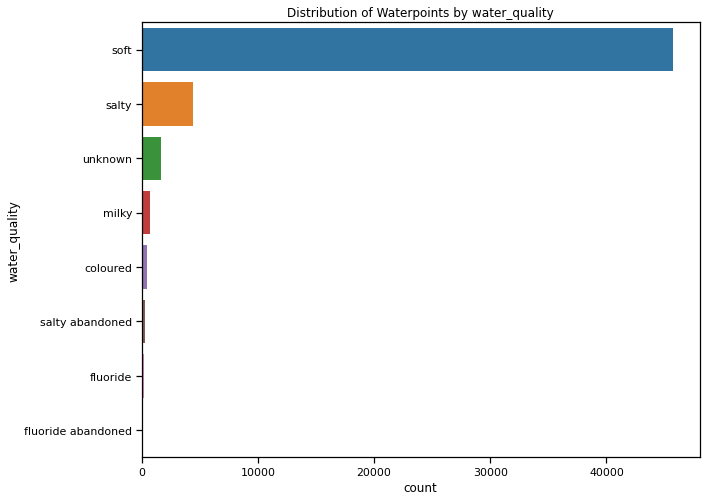

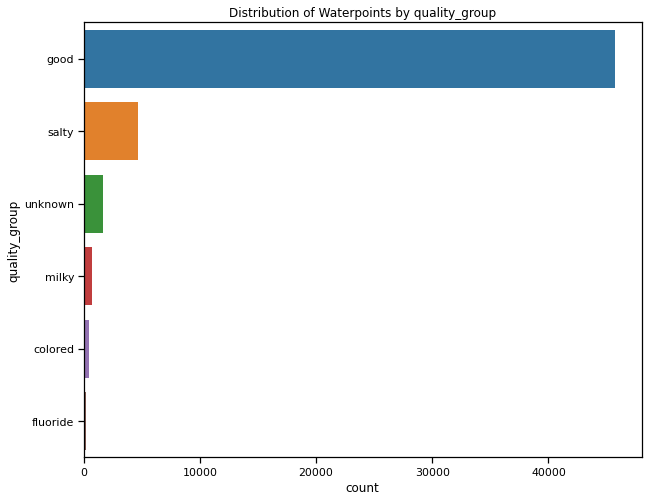

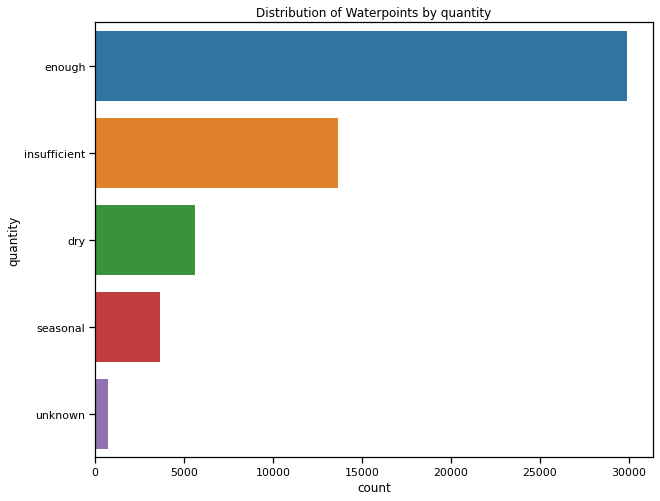

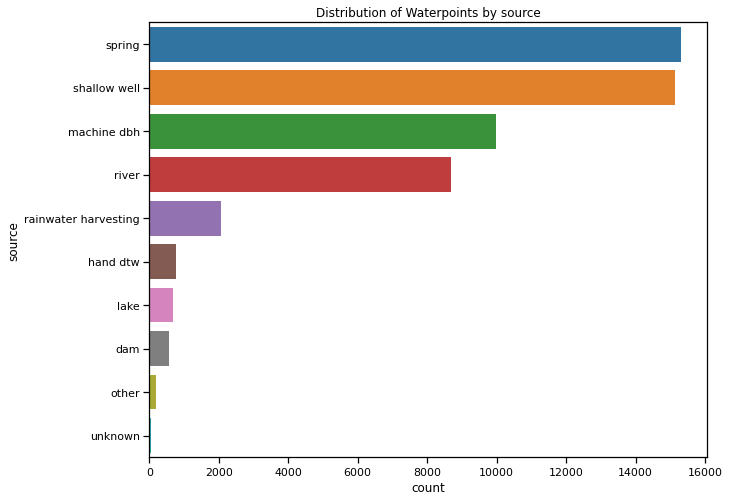

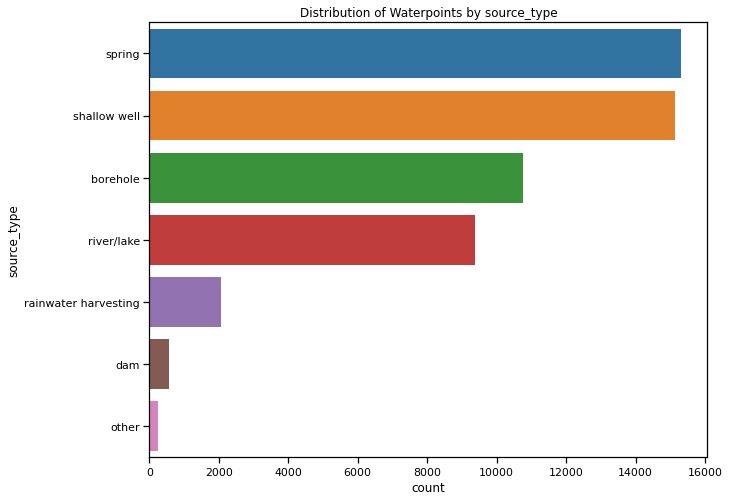

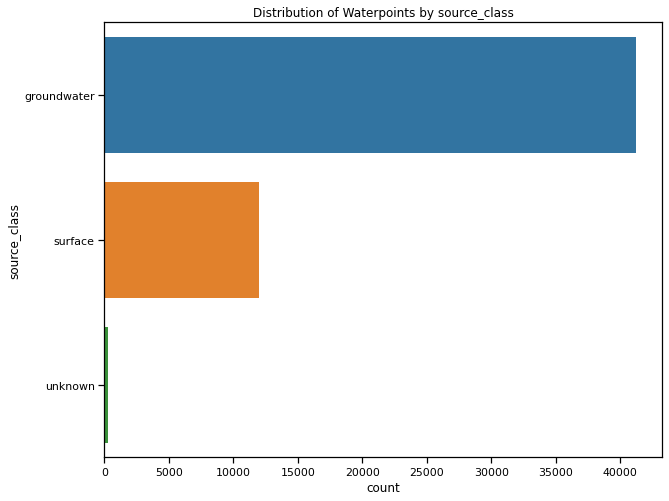

In [51]:
barplot_waterpoints(waterTable)

The function below checks two columns in our dataframe to determine one of the columns determines the values of the other column.

In [52]:
def check_dependance(col1, col2, df = X_train):   
    dict1 = {}
    dict2 = {}
    for pair in set(zip(df[col1], df[col2])):
        dict1[pair[0]] = dict1.get(pair[0],0)+1
        dict2[pair[1]] = dict2.get(pair[1],0)+1
    if max(dict1.values()) == 1 and max(dict2.values()) == 1:
        print(f'There is a bijecttion between {col1} and {col2}.')
    elif max(dict1.values()) == 1:
        print(f'There is an injection from {col1} to {col2}.')
    elif max(dict2.values()) == 1:
        print(f'There is an injection from {col2} to {col1}.')
    else:
        print('No functional dependance.')

Below I have checked for dependence between `quality_group` and `water_quality`. It looks like `water_quality` provides all of the information from `quality_group` while providing additional information about whether the waterpoint is abandoned. 

In [53]:
check_dependance('quality_group', 'water_quality', X_train)

There is an injection from water_quality to quality_group.


Similarly, I have checked for dependence between `source` and `source_type` below. It looks like `source` provides all of information from `source_type` while providing more detail about `borehole` and `river/lake` source types. It also looks like `source_type` uses an empty string to encode unknown value.

In [54]:
check_dependance('source', 'source_type', X_train)

There is an injection from source to source_type.


### Waterpoint
These variables describe particular details about the waterpoint itself.
#### Numerical
* `amount_tsh` - Total static head (amount water available to waterpoint). Total static head should roughly describe the amount of water pressure that the waterpoint can produce. 
* `population` - Population around the well.

#### Categorical
* `wpt_name` - Name of the waterpoint if there is one.
* `extraction_type` - The kind of extraction the waterpoint uses.
* `extraction_type_group` - The kind of extraction the waterpoint uses.
* `extraction_type_class` - The kind of extraction the waterpoint uses.
* `waterpoint_type` - The kind of waterpoint.
* `waterpoint_type_group` - The kind of waterpoint.

There are no missing values in this group.

In [55]:
waterpoint = X_train[['wpt_name', 'amount_tsh', 'extraction_type', 'extraction_type_group', 'extraction_type_class',
    'waterpoint_type', 'waterpoint_type_group', 'population'
   ]]
waterpoint.isnull().any()

wpt_name                 False
amount_tsh               False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
waterpoint_type          False
waterpoint_type_group    False
population               False
dtype: bool

As expected there are an enormous number of waterpoint names. This variable functions as an identifier and is unlikely to carry any meaningful information.

In [56]:
len(X_train['wpt_name'].unique())

34085

Below we plot the distribution of waterpoints with respect to each of the categorical variables in this group. 

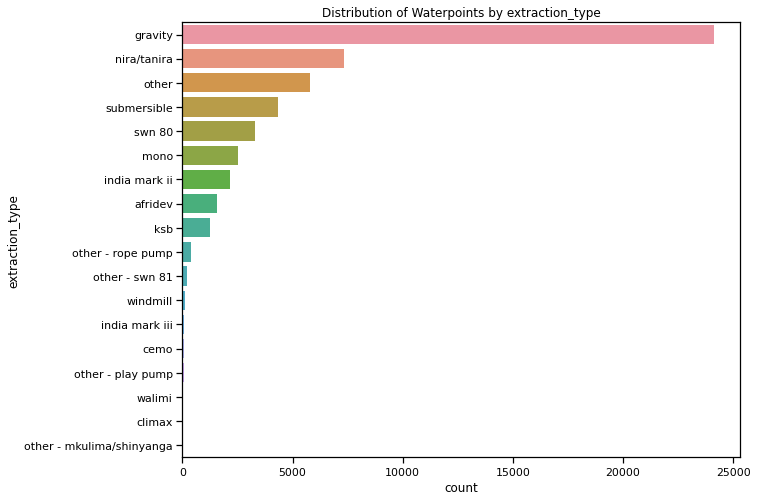

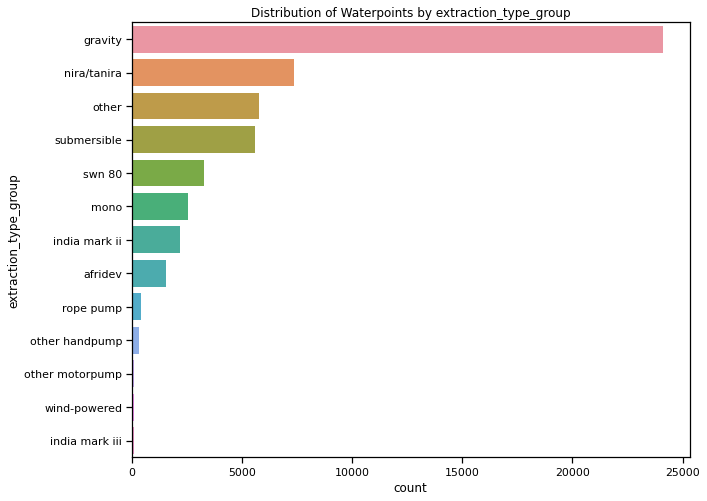

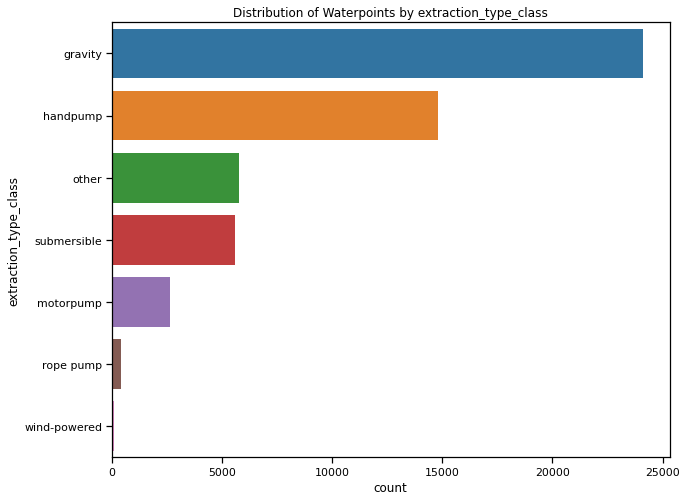

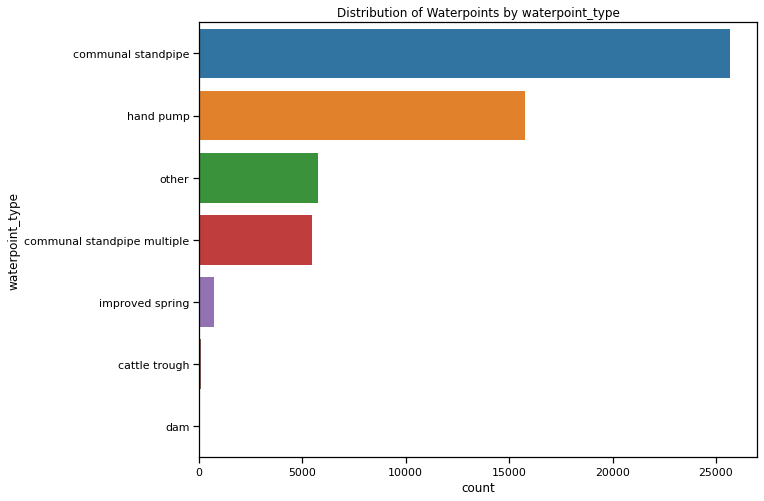

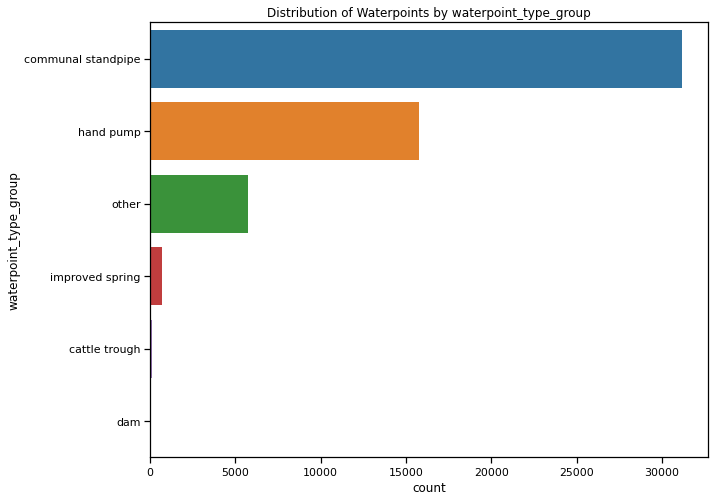

In [59]:
waterpointCat = X_train[['extraction_type', 'extraction_type_group', 'extraction_type_class',
    'waterpoint_type', 'waterpoint_type_group']]
barplot_waterpoints(waterpointCat)

Based on the naming conventions and distributions above, I want to check for functional dependence between `extraction_type`, `extraction_type_group`, `extraction_type_class`. 

In [60]:
check_dependance('extraction_type', 'extraction_type_group', X_train)

There is an injection from extraction_type to extraction_type_group.


In [61]:
check_dependance('extraction_type', 'extraction_type_class', X_train)

There is an injection from extraction_type to extraction_type_class.


In [62]:
check_dependance('extraction_type_class', 'extraction_type_group', X_train)

There is an injection from extraction_type_group to extraction_type_class.


Based on the pairwise comparisons above, `extraction_type` carries all of the information in `extraction_type_group` and `extraction_type_class`. In addition we observe that `extraction_type_group` carries all of the information from `extraction_type_class`.

Similarly, I want to check `waterpoint_type`, `waterpoint_type_group` for functional dependence.

In [63]:
check_dependance('waterpoint_type', 'waterpoint_type_group', X_train)

There is an injection from waterpoint_type to waterpoint_type_group.


It looks like `waterpoint_type` caries all of the information from `waterpoint_type_group`.

### Waterpoint Management
* `scheme_management` Who operates the waterpoint
* `scheme_name` - Who operates the waterpoint
* `permit` - If the waterpoint is permitted
* `management` - How the waterpoint is managed
* `management_group` - How the waterpoint is managed
* `payment` - What the water costs
* `payment_type` - What the water costs

In this group, `scheme_managment`, `scheme_name` and `permit` all have missing values.

In [64]:
management = X_train[['scheme_management', 'scheme_name','management',
                      'management_group', 'payment', 'payment_type', 'permit' ]]
management.isnull().any()

scheme_management     True
scheme_name           True
management           False
management_group     False
payment              False
payment_type         False
permit                True
dtype: bool

It looks like `scheme_name` has a huge number of unique values. 

In [65]:
for col in management.columns:
    print(f'- {col} has {len(management[col].unique())} unique values.')

- scheme_management has 13 unique values.
- scheme_name has 2630 unique values.
- management has 12 unique values.
- management_group has 5 unique values.
- payment has 7 unique values.
- payment_type has 7 unique values.
- permit has 3 unique values.


Below I have plotted the distribution of waterpoints with respect to each of the variables in the group excluding `scheme_name`.

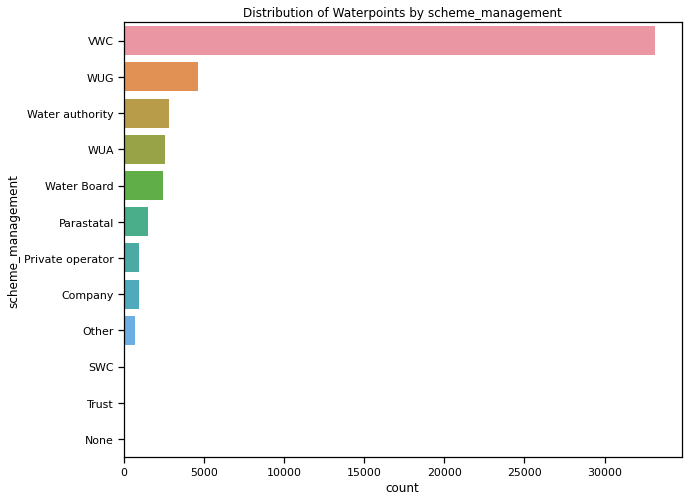

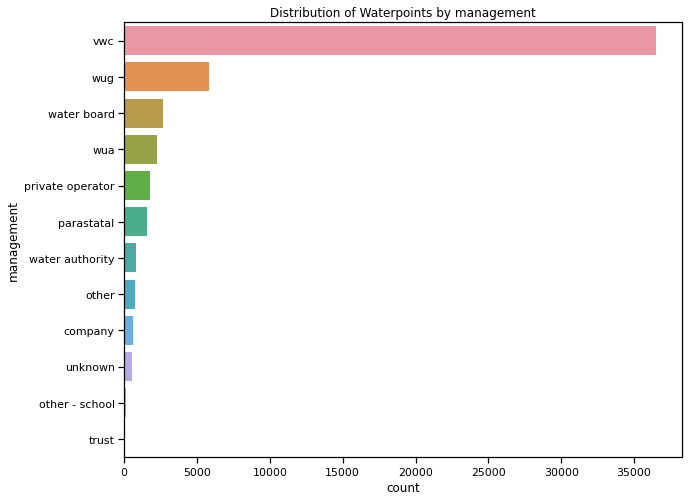

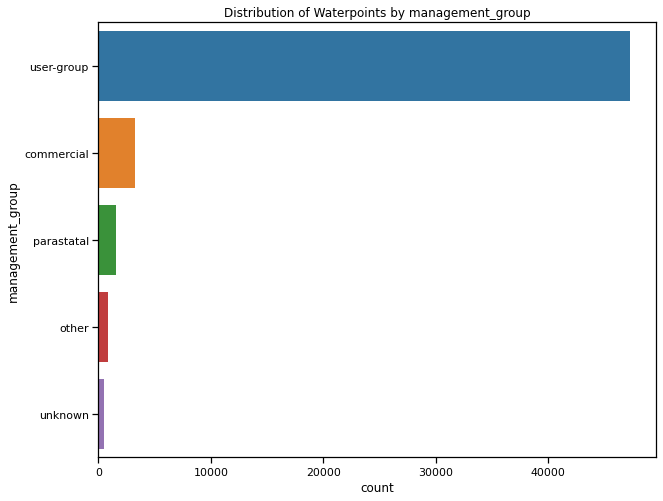

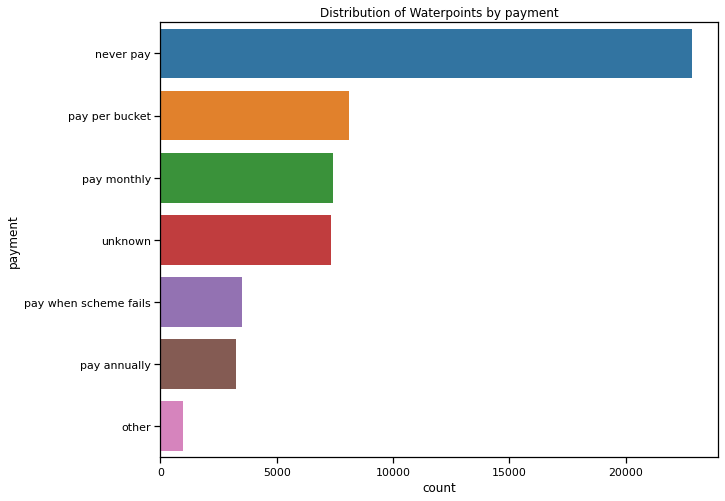

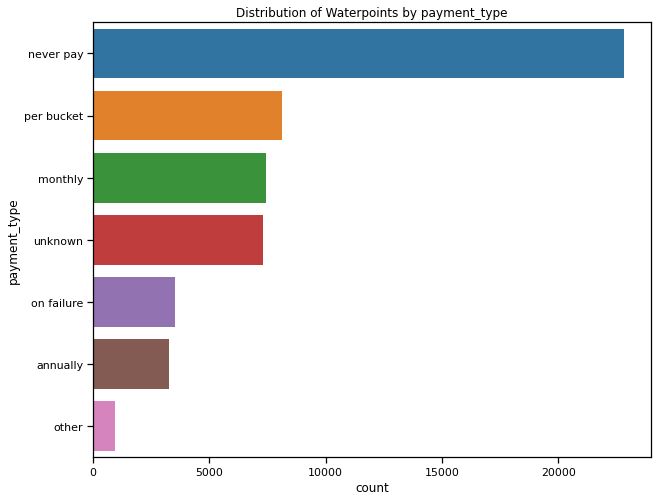

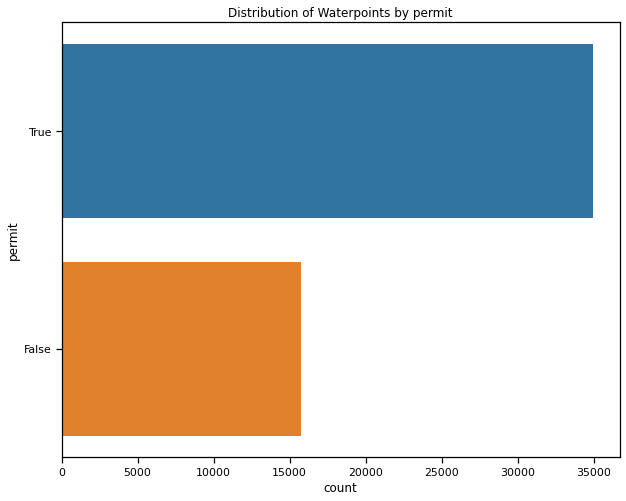

In [66]:
barplot_waterpoints(management.drop('scheme_name', axis=1))

I want to check for functional dependence between `scheme_management`,`management`, and `management_group`.

In [67]:
check_dependance('scheme_management', 'management', X_train)

No functional dependance.


In [68]:
check_dependance('scheme_management', 'management_group', X_train)

No functional dependance.


In [69]:
check_dependance('management', 'management_group', X_train)

There is an injection from management to management_group.


It looks like `management` carries all of the information from `management_group`. There is no functional dependence between `scheme_management` and `management`, however is seems likely that they are highly correlated.

### Waterpoint Installation
* `construction_year` - Year the waterpoint was constructed
* `funder` - Who funded the well
* `installer` - Organization that installed the well

In this group there are missing values in both the `funder` and `installer` variables.

In [70]:
installation = X_train[['construction_year', 'funder', 'installer']]
installation.isnull().any()

construction_year    False
funder                True
installer             True
dtype: bool

Both `funder` and `installer` have a huge number of unique values.

In [71]:
for col in installation.columns:
    print(f'- {col} has {len(installation[col].unique())} unique values.')

- construction_year has 55 unique values.
- funder has 1789 unique values.
- installer has 2037 unique values.


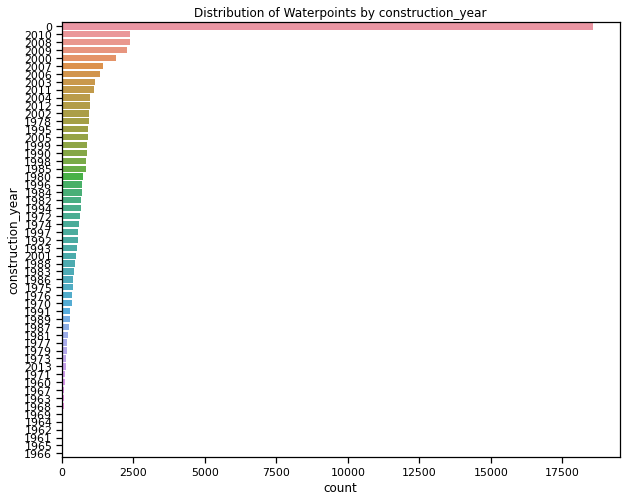

In [72]:
barplot_waterpoints(X_train[['construction_year']])

Judging by the distribution above, zero is used as a placeholder for construction year.

### Data collection
These columns pertain to the data collection process and should have no bearing on the status of a waterpoint.
* `date_recorded` - The date the row was entered
* `recorded_by` - Group entering this row of data

### Unknown
We were not able to adequately interpret these variables.
* `num_private` -
* `public_meeting` - True/False

## Conclusions
After inspecting the data, there are some issues that need to be addressed before we proceed to modeling. 
* There are several variables the explicitly depend on other variables, these should be dropped from the model to avoid issues. There are two reasonable strategies for dealing with these:
    * Keep the variable with the most granular data. There is no information loss associated with this approach, but it will increase model complexity.
    * Keep the variable with the coarser data, thereby aggregating the granular information in the finer variable. This approach reduces model complexity, but it also results in some loss of information.
* There are some variables with a huge number of values. Including these variables will greatly increase the complexity of our model and the time required to train the model.
* The Data Collection and Unknown variable groups should be excluded because any relevant information that they carry is from some unknown lurking variables.
* We will try to deal with all missing values, data encoding, and distributional issues with standard data cleaning procedures.

## Select Columns to Drop from the Model
In this section I will identify columns that should be dropped from the model. Below I have initialized the `drop_cols` list with the columns that will be dropped regardless of my approach to the other issues identified in the conclusion of the previous section.

In [73]:
drop_cols = [
    'date_recorded', 
    'recorded_by',
    'num_private',
    'public_meeting'
]

## Classifying Variables
We will need to pre-process our data in preparation for classification. Pre-processing is different for categorical and numerical variables. In order to implement different pre-pricessing flows, we must first classify all of our variables as categorical or numerical. The function below separates columns into these two classes and excludes any variables that will be dropped from the model.

In [74]:
def classify_columns(drop_cols, df=X_train):
    """Takes a dataframe and a list of columns to drop and returns:
        - cat_cols: A list of categorical columns.
        - num_cols: A list of numerical columns.
    """
    cols = df.columns
    keep_cols = [col for col in cols if col not in drop_cols]
    cat_cols = []
    num_cols = []
    for col in keep_cols:
        if df[col].dtype == object:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return cat_cols, num_cols

## Dropping Categorical Variables With Many Values

In [75]:
def drop_complex_categorical_variables(drop_cols, df=X_train, threshold= 20):
    for col in df.columns:
        if len(df[col].unique()) > threshold:
            drop_cols.append(col)
    return drop_cols

In [76]:
drop_complex_categorical_variables(drop_cols)

['date_recorded',
 'recorded_by',
 'num_private',
 'public_meeting',
 'amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'subvillage',
 'region',
 'region_code',
 'lga',
 'ward',
 'population',
 'scheme_name',
 'construction_year']

## Dropping Dependent Variables 

The function below will check for pairwise functional dependence between variables and drop variables according to the selected strategy. 

In [77]:
def drop_dependent_categorical_varables(drop_cols, df=X_train, priority='information'):
    cat_cols, num_cols = classify_columns(drop_cols)
    cat_combs = combinations(cat_cols, 2)
    for comb in cat_combs:
        dict1 = {}
        dict2 = {}
        col1 = comb[0]
        col2 = comb[1]
        col_dict = {}
        for pair in set(zip(df[col1], df[col2])):
            dict1[pair[0]] = dict1.get(pair[0],0)+1
            dict2[pair[1]] = dict2.get(pair[1],0)+1
        if max(dict1.values()) == 1 and max(dict2.values()) == 1:
            col_dict['fine'] = col1
            col_dict['coarse'] = col2
        elif max(dict1.values()) == 1:
            col_dict['fine'] = col1
            col_dict['coarse'] = col2
        elif max(dict2.values()) == 1:
            col_dict['fine'] = col2
            col_dict['coarse'] = col1
        else:
            continue
        if priority == 'information':
            drop_cols.append(col_dict['coarse'])
        elif priority == 'complexity':
            drop_cols.append(col_dict['fine'])
        else:
            pass
    return drop_cols    

In [78]:
drop_dependent_categorical_varables(drop_cols, priority='information')

['date_recorded',
 'recorded_by',
 'num_private',
 'public_meeting',
 'amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'subvillage',
 'region',
 'region_code',
 'lga',
 'ward',
 'population',
 'scheme_name',
 'construction_year',
 'extraction_type_group',
 'extraction_type_class',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity_group',
 'source_type',
 'source_class',
 'source_class',
 'waterpoint_type_group']

## Modeling Approach

Initial experiments with unoptimized models showed that the [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/index.html) performed best on this data. With that in mind, I want to build an [sklearn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to implement data preprocessing and classification. To optimize the model I will use an [sklearn grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to select the best hyper-parameters for the model and perform five-fold [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

# Data Validation
We experimented with both manual and automated feature selection, however neither approach improved model performance. Initially, we has issues with mixed data types in both the `public_meeting` and `permit` columns. The function below converts all categorical variables to strings to eliminate thoes errors. 

In [11]:
cat_cols, num_cols = classify_columns(drop_cols)
print(cat_cols)
print(num_cols)

['basin', 'scheme_management', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']
['district_code']


# Building Preprocessors
Below we build a preprocessing step for our pipeline which handles all data processing.

## Categorical Pipeline
The pipeline below executes the following three steps for all of our categorical data.
1. Convert all values in categorical columns to strings. This avoids data type errors in the following steps.
2. Fill all missing values with the string `missing`.
3. One-hot encode all categorical variables. Because this data contains categorical variables with many possible values, it is possible to encounter values in testing data that was not present in the training data. For this reason, we need to set `handel_unknown` to `ignore` so that the encoder will simply ignore unknown values in testing data.

In [12]:
def convert_categorical_to_string(data):
    return pd.DataFrame(data).astype(str)

CategoricalTypeConverter = FunctionTransformer(convert_categorical_to_string)

In [13]:
categorical_pipeline = Pipeline(steps=[
    ('typeConverter', CategoricalTypeConverter),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('standardizer', OneHotEncoder(handle_unknown='ignore',dtype=float))
])

## Numerical Pipeline
The pipeline below executes two steps:
1. Imputes missing values in any numerical column with the median value from that column.
2. Scales each variable to have mean zero and standard deviation one.

In [14]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('standardizer', PowerTransformer())
])

## Preprocessors
The column transformer below implements each of the three possible pre-processing behaviors. 
1. Apply the categorical pipeline.
2. Apply the numerical pipeline.
3. Drop the specified columns.
The if-then statement below ensures that the drop processor is only implemented if there are columns to drop. This is needed since passing an empty `drop_col` list throws an error.

In [31]:
def make_preprocessor(drop_cols=None, complexity_threshold=None, priority=None):
    if drop_cols==None:
        drop_cols = []
    if complexity_threshold != None:
        drop_cols = drop_complex_categorical_variables(drop_cols, threshold=complexity_threshold)
    if priority != None:
        drop_cols = drop_dependent_categorical_varables(drop_cols, priority=priority)
    cat_cols, num_cols = classify_columns(drop_cols)    
    if len(drop_cols) > 0:
        preprocessor = ColumnTransformer(
        transformers=[
            ('numericalPreprocessor', numerical_pipeline, num_cols),
            ('categoricalPreprocessor', categorical_pipeline, cat_cols),
            ('dropPreprocessor', 'drop', drop_cols)
        ])
    else:
        preprocessor = ColumnTransformer(
        transformers=[
            ('numericalPreprocessor', numerical_pipeline, num_cols),
            ('categoricalPreprocessor', categorical_pipeline, cat_cols)
        ])
    return preprocessor

In [32]:
drop_cols = [
    'date_recorded', 
    'recorded_by',
    'num_private',
    'public_meeting'
]
preprocessor = make_preprocessor(drop_cols=drop_cols, priority='information')

# Building Pipeline
Below we build our main pipeline which executes two steps.
1. Apply preprocessing to the raw data.
2. Fit a one vs rest classifier to the processed data using an eXtreme Gradient Boosted forest model.

In [28]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('resampler', SMOTE(random_state=random_state, n_jobs=-1,)),
        ('classifier', OneVsRestClassifier(estimator=XGBClassifier()))
    ]
)

In [29]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numericalPreprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   PowerTransformer())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('categoricalPreprocessor',
                                  

In [30]:
pipeline.score(X_test, y_test)

0.7503367003367003

# Building Parameter Grid
Below we define a grid of hyper-parameters for our pipeline that will be tested in a grid search below.

In [ ]:
parameter_grid = [
    {
        'classifier__estimator': [XGBClassifier()]
        
    }]

# Instantiate Grid Search
Below we instantiate a grid search object which will fit our pipeline for every combination of the parameters defined above. Since the competition uses accuracy as it's measure of model quality, we sill evaluate model performance in terms of accuracy. For each parameter combination, the grid search will also execute five-fold cross validation. 

In order to maximize performance, we will fit our grid search on the full provided training data set and select our best hyper-parameters based on the results of cross validation. For the purposes of local model evaluation, we will then refit the best model on our local training data and use our local testing data to produce a confusion matrix.

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=parameter_grid, 
    scoring='accuracy', 
    cv=5, 
    verbose=2, 
    n_jobs=-1,
    refit=True
)

# Fit Grid Search
Below we fit our grid search on the full training set and select the best model hyper-parameters. This step takes an Extremely long time to run.

In [ ]:
grid_search.fit(X, y)
model = grid_search.best_estimator_

# Display Results of Grid Search
Below we display the results of our grid search. We pay particular attention to `std_test_score` which will become larger if the model is over-fit. 

In [ ]:
pd.DataFrame(grid_search.cv_results_)

# Make Predictions for Validation
Below we import the testing data provided by the competition. To maximize performance we refit our model on the full training data set. Predictions are formatted and saved to CSV for submission.

In [ ]:
X_validate = pd.read_csv('../data/testing_features.csv', index_col='id')
y_validate = model.predict(X_validate)
df_predictions = pd.DataFrame(y_validate, index=X_validate.index, columns=['status_group'])
df_predictions.to_csv('../predictions/final_model.csv')

# Produce Confusion Matrix
Below we fit the model on our local training data and produce a confusion matrix using the local test data. This provides a reasonable indication of how the model performs. Because the model needs to be fit before producing the matrix, this step will take a long time to run.

In [ ]:
model.fit(X_train, y_train)
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
plot_confusion_matrix(model, X_test, y_test, ax=ax, normalize='true', include_values=True)
fig.savefig('../images/Confusion_Matrix.png', bbox_inches='tight')